# Phase 1

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

basic_stopwords = set(stopwords.words('english'))

# Initialize necessary NLP tools
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    if pd.isnull(text):
        return ""
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    tokens = word_tokenize(text)
    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]
    # Join tokens back into a string
    return ' '.join(lemmatized_tokens)


# Load datasets (Replace with your dataset paths)
train_data = pd.read_csv('train.csv')[['Title', 'Tags', 'Body', 'Y']]
valid_data = pd.read_csv('valid.csv')[['Title', 'Tags', 'Body', 'Y']]

# Apply preprocessing to train and validation data
train_data['Body'] = train_data['Body'].apply(preprocess_text)
valid_data['Body'] = valid_data['Body'].apply(preprocess_text)

train_data['Title'] = train_data['Title'].apply(preprocess_text)
valid_data['Title'] = valid_data['Title'].apply(preprocess_text)

# Vectorization using Bag-of-Words
# bow_vectorizer = CountVectorizer(max_features=5000)
# train_bow = bow_vectorizer.fit_transform(train_data['processed_body'])
# valid_bow = bow_vectorizer.transform(valid_data['processed_body'])
#
# # Vectorization using TF-IDF
# tfidf_vectorizer = TfidfVectorizer(max_features=5000)
# train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_body'])
# valid_tfidf = tfidf_vectorizer.transform(valid_data['processed_body'])

# Save processed data (Optional)
train_data.to_csv('processed_train.csv', index=False)
valid_data.to_csv('processed_valid.csv', index=False)

# Display processed train data preview
print("Processed Train Data Sample:")
train_data.head()


Processed Train Data Sample:


,Title,Tags,Body,Y
0,java repeat task everi random second,<java><repeat>,im alreadi familiar with repeat task everi n s...,LQ_CLOSE
1,whi are java option immut,<java><optional>,id like to understand whi java 8 option were d...,HQ
2,text overlay imag with darken opac react nativ,<javascript><image><overlay><react-native><opa...,i am attempt to overlay a titl over an imag wi...,HQ
3,whi ternari oper in swift is so picki,<swift><operators><whitespace><ternary-operato...,the question is veri simpl but i just could no...,HQ
4,hideshow fab with scale anim,<android><material-design><floating-action-but...,im use custom floatingactionmenu i need to imp...,HQ


# Phase 2

In [25]:
import pandas as pd
import re
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

train_data['Combined'] = train_data['Title'] + ' ' + train_data['Body']

# Combine Title and Body for Word2Vec training
train_sentences = train_data['Combined'].tolist()
train_sentences = [sentence.split() for sentence in train_sentences if isinstance(sentence, str)]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=2, workers=4)

# Save Word2Vec model
word2vec_model.save("word2vec_model.model")


In [26]:
len(train_sentences)

45000

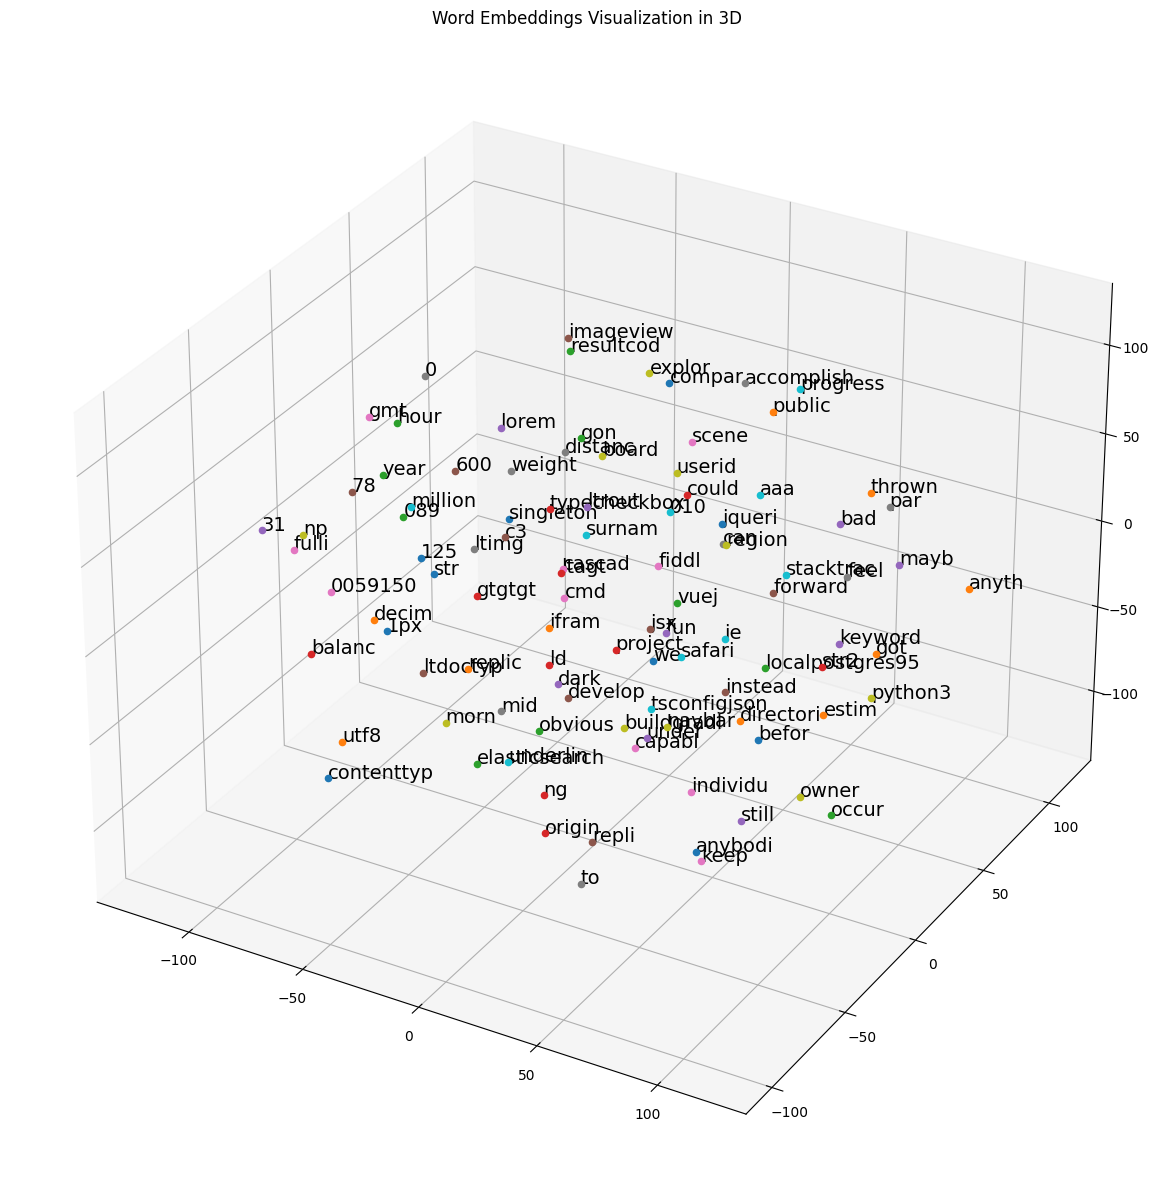

In [62]:
import random
def visualize_embeddings_3d(model, sample_size=100):
    """Visualize word embeddings using t-SNE in 3D."""
    word0 = list(model.wv.index_to_key)[:3000]
    words1 = list(model.wv.index_to_key)[100:100 + int(sample_size / 5)]
    words2 = list(model.wv.index_to_key)[1000:1000 + int(sample_size / 5)]
    words3 = list(model.wv.index_to_key)[1500:1500 + int(sample_size / 5)]
    words4 = list(model.wv.index_to_key)[2000:2000 + int(sample_size / 5)]
    words5 = list(model.wv.index_to_key)[2500:2500 + int(sample_size / 5)]

    words = random.sample(word0, sample_size)

    word_vectors = np.array([model.wv[word] for word in words])

    tsne = TSNE(n_components=3, random_state=0)
    reduced_vectors = tsne.fit_transform(word_vectors)

    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111, projection='3d')
    for i, word in enumerate(words):
        ax.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], reduced_vectors[i, 2])
        ax.text(reduced_vectors[i, 0], reduced_vectors[i, 1], reduced_vectors[i, 2], word, fontsize=14)

    plt.title("Word Embeddings Visualization in 3D")
    plt.show()


# Visualize embeddings in 3D
visualize_embeddings_3d(word2vec_model)

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate document vectors using TF-IDF weighted average
def document_vector_tfidf(doc, model, tfidf_scores):
    """Generate a document vector using TF-IDF weighted average."""
    if not isinstance(doc, str):
        return np.zeros(model.vector_size)

    # Tokenize and filter words that exist in Word2Vec vocabulary
    words = [word for word in doc.split() if word in model.wv.index_to_key]

    if not words:  # If no valid words, return a zero vector
        return np.zeros(model.vector_size)

    # Calculate weighted vectors
    weighted_vectors = [
        model.wv[word] * tfidf_scores.get(word, 0) for word in words
    ]

    if not weighted_vectors:  # Handle case where no words have TF-IDF scores
        return np.zeros(model.vector_size)

    # Return the mean of weighted vectors
    return np.mean(weighted_vectors, axis=0)

# Combine Title and Body into a single column
train_data['DocVector'] = train_data['Title'] + " " + train_data['Body']

# Fit TF-IDF vectorizer on the combined column
corpus = train_data['DocVector'].values
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
tfidf_matrix = vectorizer.transform(corpus)
feature_names = vectorizer.get_feature_names_out()

# Precompute TF-IDF scores for each document
def get_tfidf_scores(doc, vectorizer):
    """Get TF-IDF scores for a single document."""
    tfidf_vector = vectorizer.transform([doc])
    scores = dict(zip(feature_names, tfidf_vector.toarray().flatten()))
    return scores

# Calculate document vectors using TF-IDF weighted averaging
def compute_document_vectors(df, model, vectorizer):
    """Compute document vectors for a dataframe using TF-IDF and Word2Vec."""
    doc_vectors = []
    for doc in df['DocVector']:
        tfidf_scores = get_tfidf_scores(doc, vectorizer)
        vector = document_vector_tfidf(doc, model, tfidf_scores)
        doc_vectors.append(vector)
    return doc_vectors

# Generate document vectors and assign them to the column
train_data['DocVector'] = compute_document_vectors(train_data, word2vec_model, vectorizer)
train_data.to_csv('DocVector.csv', index=False)

In [85]:
# Cosine Similarity Calculation
def find_similar_questions(query, data, model, vectorizer, top_n=5):
    """Find the top_n most similar questions to the query."""
    # Precompute TF-IDF scores for the query
    tfidf_scores = get_tfidf_scores(query, vectorizer)

    # Compute query vector using TF-IDF weighted average
    query_vector = document_vector_tfidf(query, model, tfidf_scores)

    similarities = []
    for idx, row in data.iterrows():
        similarity = cosine_similarity([query_vector], [row['DocVector']])[0][0]
        similarities.append((idx, similarity))

    # Sort by similarity and get top_n results
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]
    return data.iloc[[idx for idx, _ in similarities]], [sim for _, sim in similarities]

# Example usage
query = "how to work with pandas?"
similar_questions, similarities = find_similar_questions(query, train_data, word2vec_model, vectorizer)

print("Query:", query)
print("Similar Questions:")
for i, (question, similarity) in enumerate(zip(similar_questions['Title'], similarities)):
    print(f"{i + 1}: {question} (Similarity: {similarity:.2f})")


Query: how to work with pandas?
Similar Questions:
1: findelementbyclassnam doe not work with python (Similarity: 0.93)
2: math in csharp uniti (Similarity: 0.92)
3: jspactionsomeact not work but jspactionsomeact work (Similarity: 0.91)
4: primeng how to use styleclass (Similarity: 0.90)
5: how stringbuff delet work in java (Similarity: 0.90)


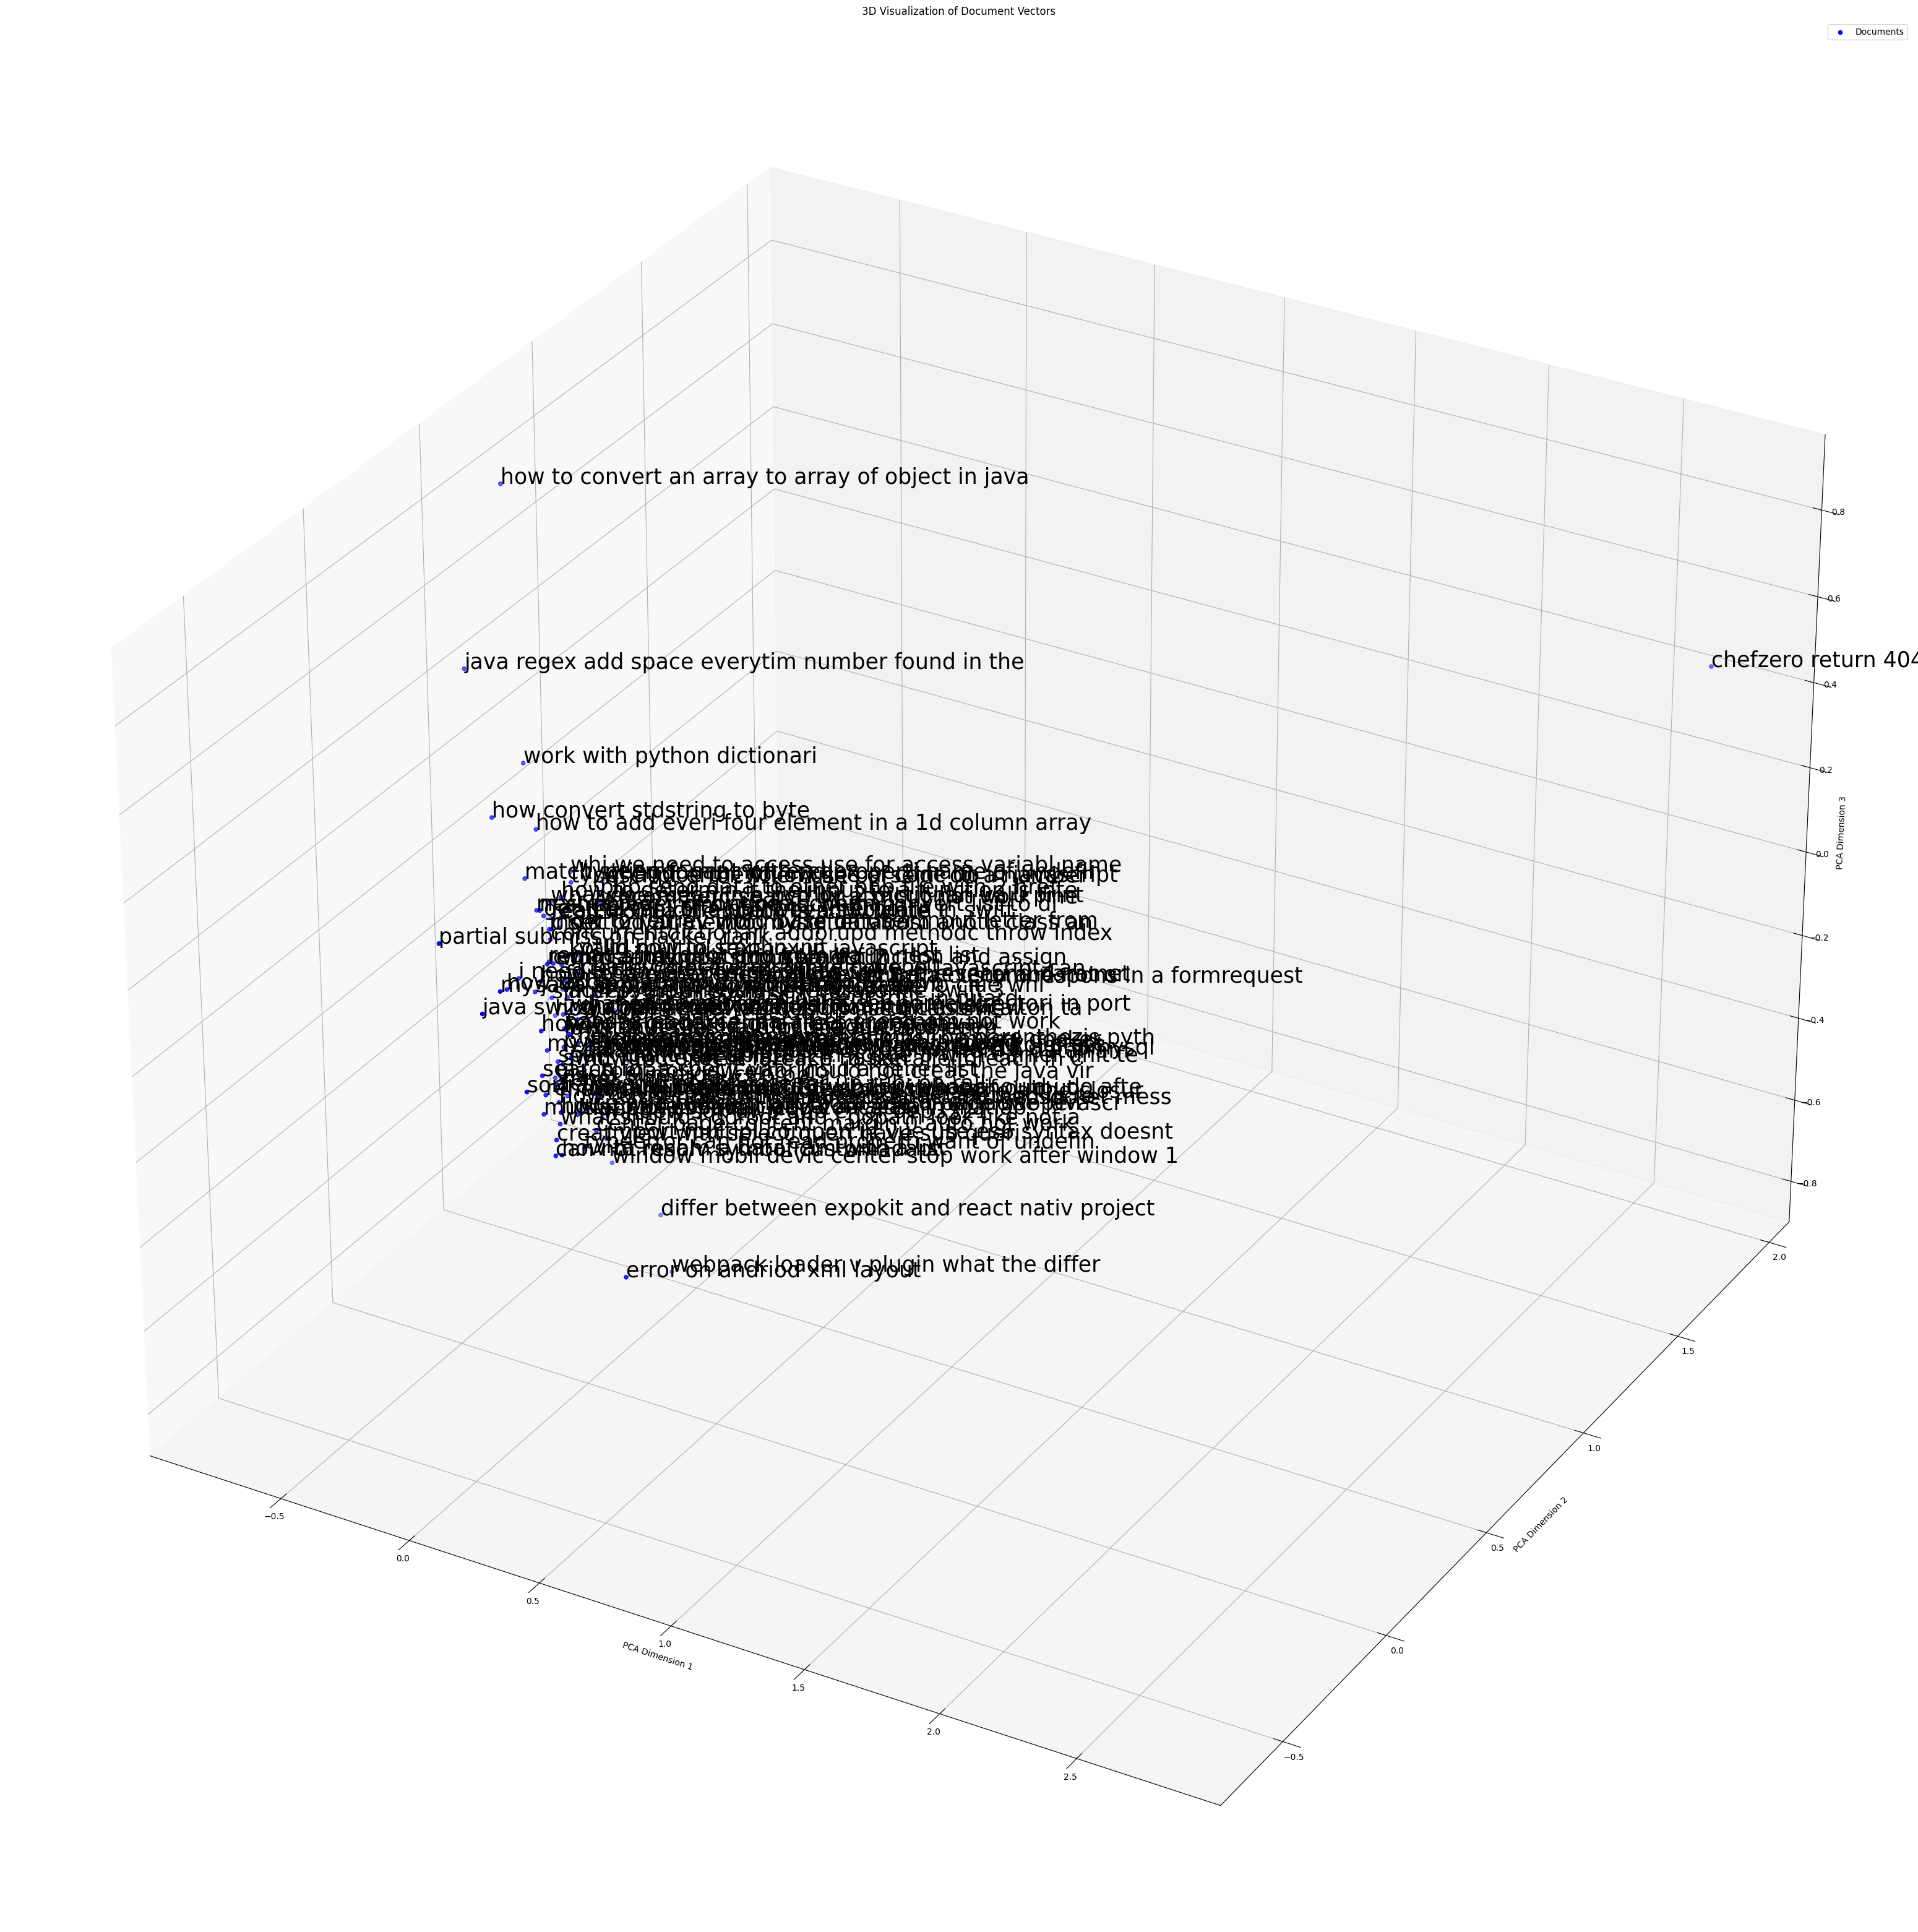

In [79]:
from sklearn.decomposition import PCA
# Visualize document vectors in 3D space
def visualize_document_vectors(data, num_samples=10):
    """Visualize document vectors for random samples in 3D space."""
    # Select random samples
    sampled_data = data.sample(n=num_samples, random_state=42)
    vectors = np.array(sampled_data['DocVector'].tolist())

    # Perform PCA to reduce dimensionality to 3D
    pca = PCA(n_components=3)
    reduced_vectors = pca.fit_transform(vectors)

    # Plot in 3D space
    fig = plt.figure(figsize=(50, 40))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], reduced_vectors[:, 2], c='blue', label='Documents')

    for i, title in enumerate(sampled_data['Title']):
        ax.text(reduced_vectors[i, 0], reduced_vectors[i, 1], reduced_vectors[i, 2], title[:50], size=25)

    ax.set_title("3D Visualization of Document Vectors")
    ax.set_xlabel("PCA Dimension 1")
    ax.set_ylabel("PCA Dimension 2")
    ax.set_zlabel("PCA Dimension 3")
    plt.legend()
    plt.show()

visualize_document_vectors(train_data, num_samples=100)

# Phase 3

In [90]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
import random

# Load preprocessed validation and training data
validation_data = pd.read_csv('processed_valid.csv')
training_data = pd.read_csv('processed_train.csv')


def get_word_embedding(text, model):
    """Generate embedding for a given text using Word2Vec model"""
    words = text.split()  # Tokenize
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Average of word vectors
    else:
        return np.zeros(model.vector_size)  # Zero vector if no valid words

# Step 1: Prepare validation data
# Randomly select 10% of validation data
random.seed(42)  # For reproducibility
validation_subset = validation_data.sample(frac=0.1)

# Step 2: Load the Word2Vec model
word2vec_model = Word2Vec.load('word2vec_model.model')

# Convert training data to embeddings
train_embeddings = np.array([get_word_embedding(row['Body'], word2vec_model) for _, row in training_data.iterrows()])

# Initialize KNN
k = 5
knn = NearestNeighbors(n_neighbors=k, metric='cosine')
knn.fit(train_embeddings)

# Step 3: Tagging the validation subset
predicted_tags = []
for _, row in validation_subset.iterrows():
    # Get embedding for validation row
    validation_vector = get_word_embedding(row['Body'], word2vec_model)

    # Find k nearest neighbors
    distances, indices = knn.kneighbors([validation_vector])

    # Collect tags from nearest neighbors
    neighbor_tags = []
    for idx in indices[0]:
        neighbor_tags.extend(training_data.iloc[idx]['Tags'].split())

    # Deduplicate tags and append to predictions
    predicted_tags.append(list(set(neighbor_tags)))

# Step 4: Evaluate predictions
# Convert predicted tags into comparable format
validation_subset['Predicted_Tags'] = predicted_tags
validation_subset['Correct'] = validation_subset.apply(
    lambda row: bool(set(row['Tags'].split()) & set(row['Predicted_Tags'])), axis=1
)
accuracy = validation_subset['Correct'].mean()
print(f"Tagging Accuracy: {accuracy * 100:.2f}%")

# Step 5: Show examples
successful = validation_subset[validation_subset['Correct']].sample(3)
unsuccessful = validation_subset[~validation_subset['Correct']].sample(3)

print("\nSuccessful Predictions:")
print(successful[['Body', 'Tags', 'Predicted_Tags']])

print("\nUnsuccessful Predictions:")
print(unsuccessful[['Body', 'Tags', 'Predicted_Tags']])


Tagging Accuracy: 7.53%

Successful Predictions:
                                                    Body          Tags  \
14632  whi is it wrong to creat a list use thi x list...      <python>   
5499   i have an object liter such a the follow all p...  <typescript>   
5728   how to save a websit shortcut on your desktop ...  <javascript>   

                                          Predicted_Tags  
14632  [<python><pandas><expression><keyword>, <pytho...  
5499   [<typescript>, <javascript><unit-testing><type...  
5728   [<php><ios><ipa>, <java><netbeans><jar><derby>...  

Unsuccessful Predictions:
                                                   Body  \
218   none type object ha no attribut text line 16 f...   
8872  how do i run a c code on xcode and on the io s...   
7731  im tri to set up a comment page in my app and ...   

                                                 Tags  \
218                       <python-3.x><beautifulsoup>   
8872                      <c++><xcode><i